## to do some day - 
- update information about this notebook and what it does 

Merger definition for this project: 
 - RG 2015, 2017, Patton 2020, Ventou 2020 all use same definition of merging:
     - when a subhalo has two or more direct progenitors, the progenitors "merged"
     - can check the subhalo descendent ID's and find the first snapshot where they are the same? (would this cover places where the subhalo descendent has a progenitor that skips a snapshot? -> can check by doing Root Descendant ID check as well.)
     

to do: 
- quantify how many pairs will merge in the future
- quantify the fraction that merge as a function of the separation of the pair at z=1, 1.5, 2
- need to pull out all pairs at z=1, 1.5, 2 and their orbits


"merged" snapshot after the descendant ID is the same number at a single snapshot

## To do for Oct. 17:
- make function to calculate the fraction for a given redshift
- find the merger fractions for z=1,1.5,2
- save the data for the merger fractions

- think about next steps, i.e. saving separations
- think about how to quantify the fraction that merge as a function of the separation (bin in separation at the redshift, find fraction of things in that separation that merge)

**Done:**
- implement merger definition for one pair in z=1.5
- check for easiest way to define (and when?) 
- get merged fraction for z=1.5 via RootDescendantID method
- get merged fraction for z=1.5 via merger definition

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

Goal: 
- get first z=1.5 pair (snapshot 40), and pull out matched lists of descendant info

In [9]:
# assign all the data to a dictionary and close hdf5 file
f = h5py.File(f"../data/lowmass_z1p5.hdf5", 'r')
pairs = {}
for key, val in f.items():
    if key == "Header":
        continue
    pairs[key]=np.array(val)
f.close()
    

In [8]:
# grab subfind id's of first pair
pair1 = pairs['Sub1 ID'][0]
pair2 = pairs['Sub2 ID'][0]

mass1 = pairs['Sub1 Mass'][0]
mass2 = pairs['Sub2 Mass'][0]

In [26]:
# get the merger trees for each subhalo and make sure the mass makes sense
# note: all values returned by the merger trees past, future, and merged 
#     branches are in simulation units
treedict = {}
for sub in [pair1,pair2]:
    treedict[sub] = TraceMergerTree(snapshot=40,physics="hydro",sim="TNG",subfindID=sub)

In [28]:
# converting to physical units for TNG and making sure masses are correct at z=1.5
little_h = 0.6774

print(mass1,treedict[pair1].mergedbranch['SubhaloMass'][treedict[pair1].mergedbranch['SnapNum']==40][0]/little_h)
print(mass2,treedict[pair2].mergedbranch['SubhaloMass'][treedict[pair2].mergedbranch['SnapNum']==40][0]/little_h)

35.549774260023966 35.549774260023966
27.455131951988992 27.455131951988992


- 'DescendantID'
- 'FirstProgenitorID'
- 'FirstSubhaloInFOFGroupID'
- 'LastProgenitorID'
- 'MainLeafProgenitorID'
- 'Mass'
- 'MassHistory'
- 'NextProgenitorID'
- 'NextSubhaloInFOFGroupID'
- 'NumParticles'
- 'RootDescendantID'
- 'SnapNum'
- 'SubfindID'

If I want to make a loop that goes through and figures out the location/snapshot of merger, I can FIRST check for RootDescendantID to see if they are the same, and if they are, then they should have the same Descendant ID or Last Progenitor ID up until the snapshot where they merged (i.e. I can count them)

In [39]:
# this is where the "previous progenitor" is the same (meaning that they have merged at snapshot 38)
np.where(treedict[pair1].mergedbranch['LastProgenitorID'][0:50] == treedict[pair2].mergedbranch['LastProgenitorID'][0:50])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),)

In [44]:
# this is where the "next descendent" is the same (so they will merge at the second to last snapshot)
np.where(treedict[pair1].mergedbranch['DescendantID'][0:50] == treedict[pair2].mergedbranch['DescendantID'][0:50])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),)

In [61]:
print("The first snapshot AFTER merger is:",treedict[pair1].mergedbranch['SnapNum'][np.where(treedict[pair1].mergedbranch['DescendantID'][0:50] == treedict[pair2].mergedbranch['DescendantID'][0:50])][-1])
print("The first snapshot before merger is:",treedict[pair1].mergedbranch['SnapNum'][np.where(treedict[pair1].mergedbranch['LastProgenitorID'][0:50] == treedict[pair2].mergedbranch['LastProgenitorID'][0:50])][-1])
print("The first snapshot before merger is:",treedict[pair1].mergedbranch['SnapNum'][np.where(treedict[pair1].mergedbranch['SubfindID'][0:50] == treedict[pair2].mergedbranch['SubfindID'][0:50])][-1])



The first snapshot AFTER merger is: 60
The first snapshot before merger is: 61
The first snapshot before merger is: 61


___

## Calculating full merger fraction for z=1.5

**Notes:**

I can use the Descendant ID to identify the snapshot where the two subhalos will next merge. 

Now let's try to go through each of the pairs, and I will save 3 things: 
- Whether the pair merges via the 'RootDescendantID'
- Whether the pair merges via the 'DescendantID'
- What the snapshot after the 'DescendantID' equivalence happens

The below script first checks if the RootDescendantID of the primary and secondary of each pair is the same (meaning they merge at some point in the simulation). If they do merge, mask the snapshots where both subhalos exist simultaneously and determine when they have the same descendant ID, and output the "merger snapshot" defined as the snapshot of the subhalo that results from merger. 

*Might need to check if the groupID is the same at all previous snapshots (meaning they are "infalling") or to figure out how long it has been since infall.*

In [105]:
merger_root, merger_desc, snap_merged = np.zeros((3,len(pairs['Sub1 ID'])))

for ind in range(len(pairs['Sub1 ID'])):
    primary_id = pairs['Sub1 ID'][ind]
    secondary_id = pairs['Sub2 ID'][ind]
    
    treedict = {}
    for sub in [primary_id,secondary_id]:
        treedict[sub] = TraceMergerTree(snapshot=40,physics="hydro",sim="TNG",subfindID=sub)

    tree_primary = treedict[primary_id].mergedbranch
    tree_secondary = treedict[secondary_id].mergedbranch
    
    # check if root descendant ID is the same between the two halos
    root1 = tree_primary['RootDescendantID'][0]
    root2 = tree_secondary['RootDescendantID'][0]
    check_root = root1 == root2
    
    if check_root:
        merger_root[ind] = True
    
        # make masks to check descendants 
        snaps1 = tree_primary['SnapNum']
        snaps2 = tree_secondary['SnapNum']

        mask1 = np.isin(snaps1, snaps2)
        mask2 = np.isin(snaps2, snaps1)

        desc1 = tree_primary['DescendantID'][mask1]
        desc2 = tree_secondary['DescendantID'][mask2]
        
        try:
            ind_premerge = np.where(desc1==desc2)[0][-1]
            ind_postmerge = np.where(desc1==desc2)[0][-2]
            snap_premerge = tree_primary['SnapNum'][mask1][ind_premerge]
            snap_postmerge = tree_primary['SnapNum'][mask1][ind_postmerge]
            
            merger_desc[ind] = True
            snap_merged[ind] = snap_postmerge
        
        except IOError:
            print('Error in the snapshot number')
            
merger_dict = {"MergersRoot":merger_root,"MergersDescendant":merger_desc,"MergerSnapshot":snap_merged}
merger_dict

{'MergersRoot': array([1., 0., 1., ..., 1., 1., 1.]),
 'MergersDescendant': array([1., 0., 1., ..., 1., 1., 1.]),
 'MergerSnapshot': array([61.,  0., 73., ..., 43., 41., 44.])}

In [114]:
mergerfrac_root = np.count_nonzero(merger_dict['MergersRoot']) / len(merger_dict['MergersRoot'])
mergerfrac_desc = np.count_nonzero(merger_dict['MergersDescendant']) / len(merger_dict['MergersDescendant'])
print(f"Merger fraction defined based on the RootDescendantID: {mergerfrac_root:.3f}")
print(f"Merger fraction defined based on the Descendant ID: {mergerfrac_desc:.3f}")
print(f"Average snapshot of mergers: {np.mean(merger_dict['MergerSnapshot'][merger_dict['MergerSnapshot']!=0]):.3f}")


Merger fraction defined based on the RootDescendantID: 0.901
Merger fraction defined based on the Descendant ID: 0.901
Average snapshot of mergers: 50.901


## Creating merger fraction at z=1,1.5,2

Save flag if pair merges before z=0, time of merger, and separation at the given snapshot

In [76]:
def calculate_mergerfrac(red):
    """Note: this function is presently only defined for redshifts z=1, 1.5, 2"""
    
    snap_dict = {"z=1":50,"z=1.5":40,"z=2":33}
    snapshot = snap_dict[f"z={red}"]

    # assign all imported data to a dictionary and close hdf5 file
    f = h5py.File(f"../data/lowmass_{snapshot}.hdf5", 'r')
    pairs = {}
    for key, val in f.items():
        if key == "Header":
            continue
        pairs[key] = np.array(val)
        
        redshift = f["Header"].attrs["Redshift"]
    f.close()
    
    # define characteristic values for the sim/snapshot
    scale = 1/(1+redshift)
    little_h = 0.6774

    # create empty arrays to save data to
    merger_root, merger_desc, snap_merged, sep_now = np.zeros((4,len(pairs['Sub1 ID'])))

    # for each subhalo pair, check if they merge and update data arrays
    for ind in range(len(pairs['Sub1 ID'])):
        primary_id = pairs['Sub1 ID'][ind]
        secondary_id = pairs['Sub2 ID'][ind]

        treedict = {}
        for sub in [primary_id,secondary_id]:
            treedict[sub] = TraceMergerTree(snapshot=snapshot,physics="hydro",sim="TNG",subfindID=sub)

        tree_primary = treedict[primary_id].mergedbranch
        tree_secondary = treedict[secondary_id].mergedbranch

        # check if root descendant ID is the same between the two halos
        root1 = tree_primary['RootDescendantID'][0]
        root2 = tree_secondary['RootDescendantID'][0]
        check_root = root1 == root2

        if check_root:
            merger_root[ind] = True

            # find overlapping descendant IDs
            desc_mask1 = np.isin(tree_primary['DescendantID'],tree_secondary['DescendantID'])
            desc_mask2 = np.isin(tree_secondary['DescendantID'],tree_primary['DescendantID'])

            snap_overlap1 = tree_primary["SnapNum"][desc_mask1]
            snap_overlap2 = tree_secondary["SnapNum"][desc_mask2]

            if snap_overlap1[-1] == snap_overlap2[-1]:
                merger_desc[ind] = True
                snap_merged[ind] = snap_overlap1[-1]+1

            elif abs(snap_overlap1[-1]-snap_overlap2[-1])==1:
                merger_desc[ind] = True
                snap_merged[ind] = np.min(np.intersect1d(snap_overlap1,snap_overlap2))
            
        else: 
            merger_root[ind] = False
            merger_desc[ind] = False
            snap_merged[ind] = 0
            
        pos1 = pairs["Sub1 Pos"][ind] # in physical kpc
        pos2 = pairs["Sub2 Pos"][ind] # in physical kpc
            
        dist_phys = np.linalg.norm(vector(pos1,pos2,75000*(scale)/little_h))
        sep_now[ind] = dist_phys

    merger_dict = {"MergersRoot":merger_root,"MergersDescendant":merger_desc,"MergerSnapshot":snap_merged,"Separation":sep_now}

    # defining the attributes that will be assigned to the merger dictionary
    info_dict = {"MergersRoot":"If true: The halos have the same RootDescendantID at z=0", 
        "MergersDescendant":"If true: The halos have the same descendantID at some snapshot between given snapshot and z=0",
        "MergerSnapshot":"Snapshot at which 'merger' has occured",
        "Separation":"Physical separation between the pair at the given snapshot"}

    # defining the dictionary that holds the header infomation about the data file
    header_dict = {"Details":f"Merged fraction and info for z={red}",
                "Snapshot":snapshot,
                "Redshift":redshift,
                "Simulation":"TNG100-1"}

    # creating and saving the file
    f = h5py.File(f"../data/merged-fraction_{snapshot}.hdf5", 'w')

    dset = f.create_group('/Header')
    for key in header_dict.keys():
        dset.attrs[key] = header_dict[key]

    for key, val in merger_dict.items():
        val = np.array(val)
        dset = f.create_dataset(f'/{key}', 
                                shape=val.shape,
                                dtype=val.dtype)
        dset.attrs[key] = info_dict[key]
        dset[:] = val

    f.close()    

    # print statement when function completes successfully
    print(f"Saved merged fraction info for z={red}")


In [79]:
calculate_mergerfrac(1.5)

Saved merged fraction info for z=1.5


In [78]:
calculate_mergerfrac(1)

Saved merged fraction info for z=1


In [77]:
calculate_mergerfrac(2)

Saved merged fraction info for z=2


In [80]:
for i in [33, 40, 50]:
    print("At snapshot ",i, ":")
    print("-----------------------")
    f = h5py.File(f"../data/merged-fraction_{i}.hdf5", 'r')
    data_dict = {}
    for key, val in f.items():
        if key == "Header":
            continue
        data_dict[key] = np.array(val)
    f.close()

    mergerfrac_root = np.count_nonzero(data_dict['MergersRoot']) / len(data_dict['MergersRoot'])
    mergerfrac_desc = np.count_nonzero(data_dict['MergersDescendant']) / len(data_dict['MergersDescendant'])
    print(f"Merger fraction defined based on the RootDescendantID: {mergerfrac_root:.3f}")
    print(f"Merger fraction defined based on the Descendant ID: {mergerfrac_desc:.3f}")
    print(f"Average snapshot of mergers: {np.mean(data_dict['MergerSnapshot'][data_dict['MergerSnapshot']!=0]):.3f}")
    print(f"Average separation of pairs: {np.mean(data_dict['Separation']):.3f}")



At snapshot  33 :
-----------------------
Merger fraction defined based on the RootDescendantID: 0.946
Merger fraction defined based on the Descendant ID: 0.946
Average snapshot of mergers: 41.701
Average separation of pairs: 62.337
At snapshot  40 :
-----------------------
Merger fraction defined based on the RootDescendantID: 0.901
Merger fraction defined based on the Descendant ID: 0.901
Average snapshot of mergers: 50.788
Average separation of pairs: 75.256
At snapshot  50 :
-----------------------
Merger fraction defined based on the RootDescendantID: 0.848
Merger fraction defined based on the Descendant ID: 0.848
Average snapshot of mergers: 63.587
Average separation of pairs: 88.355


## Merger fraction as function of separation at z=1,1.5,2

In [3]:
data_dict = {}
for i in [33, 40, 50]:
    f = h5py.File(f"../data/merged-fraction_{i}.hdf5", 'r')
    data_dict[i] = {}
    for key, val in f.items():
        if key == "Header":
            continue
        data_dict[i][key] = np.array(val)
    f.close()

In [4]:
data_dict[40]['MergersRoot']

array([1., 0., 1., ..., 1., 1., 1.])

In [5]:
sep_bins = np.arange(0,310,20)
merged_vals,_ = np.histogram(data_dict[40]['Separation'][data_dict[40]['MergersRoot']==1],bins=sep_bins)
all_vals,_ = np.histogram(data_dict[40]['Separation'],bins=sep_bins)

div = np.array(merged_vals)/np.array(all_vals)
print(merged_vals)
print(all_vals)

[220 311 120  98 100 106 100  60  33  22  16   8   1   0   1]
[220 313 131 109 120 125 122  73  48  28  21  10   4   0   3]


/tmp/ipykernel_49234/930228465.py:5: RuntimeWarning: invalid value encountered in divide
  div = np.array(merged_vals)/np.array(all_vals)


In [6]:
div

array([1.        , 0.99361022, 0.91603053, 0.89908257, 0.83333333,
       0.848     , 0.81967213, 0.82191781, 0.6875    , 0.78571429,
       0.76190476, 0.8       , 0.25      ,        nan, 0.33333333])

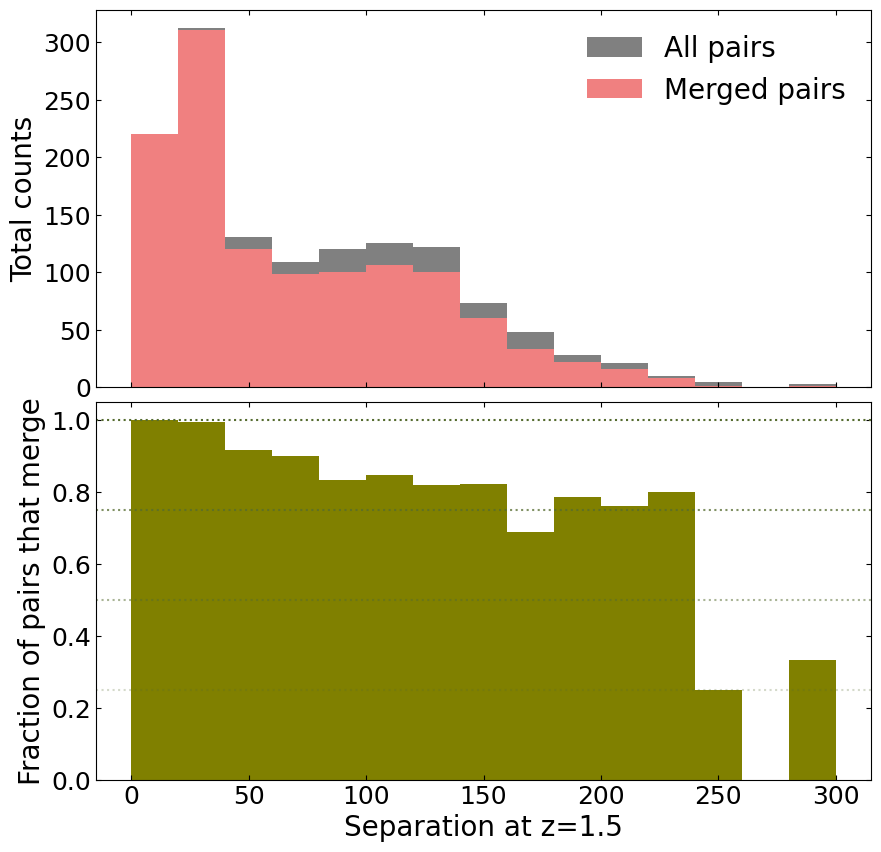

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharey=False, sharex=True, gridspec_kw={'width_ratios': [1], 'height_ratios':[1,1],'wspace': 0.10,"hspace":0.04})

ax[0].stairs(all_vals,sep_bins,fill=True,color="grey",label="All pairs")
ax[0].stairs(merged_vals,sep_bins,fill=True,color="lightcoral",label="Merged pairs")
ax[1].stairs(div,sep_bins,fill=True,color="olive",)
for i in np.arange(0,1.25,0.25):
    ax[1].axhline(i, alpha=i,linestyle="dotted",color="darkolivegreen")

ax[1].set_xlabel("Separation at z=1.5")
ax[0].set_ylabel("Total counts")
ax[1].set_ylabel("Fraction of pairs that merge")
ax[0].legend(frameon=False)

plt.savefig(f"{paths.path_plots}1_merged-fraction/mergedfraction.pdf")
plt.show()

Merged sample, not merged sample, full sample, 
Observability windows (time spent in certain separation bins) for merged and non-merged (look at Lotz 2011 to see how they plot this?) 


## GRAVEYARD SPOOKY

In [17]:
red = 2
snap_dict = {"z=1":50,"z=1.5":40,"z=2":33}
snapshot = snap_dict[f"z={red}"]

# assign all imported data to a dictionary and close hdf5 file
f = h5py.File(f"../data/lowmass_{snapshot}.hdf5", 'r')
pairs = {}
for key, val in f.items():
    if key == "Header":
        continue
    pairs[key] = np.array(val)

    redshift = f["Header"].attrs["Redshift"]
f.close()

# define characteristic values for the sim/snapshot
scale = 1/(1+redshift)
little_h = 0.6774

In [71]:
# create empty arrays to save data to
merger_root, merger_desc, snap_merged, sep_now = np.zeros((4,len(pairs['Sub1 ID'])))

# for each subhalo pair, check if they merge and update data arrays
for ind in range(len(pairs['Sub1 ID']))[540:545]:
    primary_id = pairs['Sub1 ID'][ind]
    secondary_id = pairs['Sub2 ID'][ind]

    pos1 = pairs["Sub1 Pos"][ind] # in physical kpc
    pos2 = pairs["Sub2 Pos"][ind] # in physical kpc

    treedict = {}
    for sub in [primary_id,secondary_id]:
        treedict[sub] = TraceMergerTree(snapshot=snapshot,physics="hydro",sim="TNG",subfindID=sub)

    tree_primary = treedict[primary_id].mergedbranch
    tree_secondary = treedict[secondary_id].mergedbranch

    # check if root descendant ID is the same between the two halos
    root1 = tree_primary['RootDescendantID'][0]
    root2 = tree_secondary['RootDescendantID'][0]
    check_root = root1 == root2

    if check_root:
        merger_root[ind] = True

        # make masks to check descendants 
        snaps1 = tree_primary['SnapNum']
        snaps2 = tree_secondary['SnapNum']

        mask1 = np.isin(snaps1, snaps2)
        mask2 = np.isin(snaps2, snaps1)

        desc1 = tree_primary['DescendantID'][mask1]
        desc2 = tree_secondary['DescendantID'][mask2]

        try:
            ind_premerge = np.where(desc1==desc2)[0][-1]
            ind_postmerge = np.where(desc1==desc2)[0][-2]
            snap_premerge = tree_primary['SnapNum'][mask1][ind_premerge]
            snap_postmerge = tree_primary['SnapNum'][mask1][ind_postmerge]

            merger_desc[ind] = True
            snap_merged[ind] = snap_postmerge        

            print(snap_merged[ind])


            dist_phys = np.linalg.norm(vector(pos1,pos2,75000*(scale)/little_h))

            sep_now[ind] = dist_phys

        except IOError:
            print('Error in the snapshot number')

merger_dict = {"MergersRoot":merger_root,"MergersDescendant":merger_desc,"MergerSnapshot":snap_merged,"Separation":sep_now}


39.0
34.0
41.0


IndexError: index -2 is out of bounds for axis 0 with size 1

In [55]:
tree_primary['SnapNum'][desc1==desc2][-1]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38], dtype=int16)

In [72]:
# create empty arrays to save data to
merger_root, merger_desc, snap_merged, sep_now = np.zeros((4,len(pairs['Sub1 ID'])))

# for each subhalo pair, check if they merge and update data arrays
for ind in range(len(pairs['Sub1 ID']))[540:545]:
    primary_id = pairs['Sub1 ID'][ind]
    secondary_id = pairs['Sub2 ID'][ind]

    pos1 = pairs["Sub1 Pos"][ind] # in physical kpc
    pos2 = pairs["Sub2 Pos"][ind] # in physical kpc

    treedict = {}
    for sub in [primary_id,secondary_id]:
        treedict[sub] = TraceMergerTree(snapshot=snapshot,physics="hydro",sim="TNG",subfindID=sub)

    tree_primary = treedict[primary_id].mergedbranch
    tree_secondary = treedict[secondary_id].mergedbranch

    # check if root descendant ID is the same between the two halos
    root1 = tree_primary['RootDescendantID'][0]
    root2 = tree_secondary['RootDescendantID'][0]
    check_root = root1 == root2

    if check_root:
        merger_root[ind] = True

        # make masks to check descendants 
        snaps1 = tree_primary['SnapNum']
        snaps2 = tree_secondary['SnapNum']

        mask1 = np.isin(snaps1, snaps2)
        mask2 = np.isin(snaps2, snaps1)
            
#         try:
        # find overlapping descendant IDs
        desc_mask1 = np.isin(tree_primary['DescendantID'],tree_secondary['DescendantID'])
        desc_mask2 = np.isin(tree_secondary['DescendantID'],tree_primary['DescendantID'])

        snap_overlap1 = tree_primary["SnapNum"][desc_mask1]
        snap_overlap2 = tree_secondary["SnapNum"][desc_mask2]

        if snap_overlap1[-1] == snap_overlap2[-1]:
            merger_desc[ind] = True
            snap_merged[ind] = snap_overlap1[-1]+1

        elif abs(snap_overlap1[-1]-snap_overlap2[-1])==1:
            merger_desc[ind] = True
            snap_merged[ind] = np.min(np.intersect1d(snap_overlap1,snap_overlap2))
            
        print(snap_merged[ind])

        dist_phys = np.linalg.norm(vector(pos1,pos2,75000*(scale)/little_h))
        sep_now[ind] = dist_phys

#         except IOError:
#             print('Error in the snapshot number')
            
#         except IOError:
#             print('Error in the snapshot number')    

merger_dict = {"MergersRoot":merger_root,"MergersDescendant":merger_desc,"MergerSnapshot":snap_merged,"Separation":sep_now}

39.0
34.0
41.0
99.0
34.0


In [59]:
yy = tree_primary["SnapNum"][np.isin(tree_primary['DescendantID'],tree_secondary['DescendantID'])]
xx = tree_secondary["SnapNum"][np.isin(tree_secondary['DescendantID'],tree_primary['DescendantID'])]
# print(np.min(np.intersect1d(xx,yy))
np.intersect1d(xx,yy)

array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int16)

In [65]:
xx=[99,98]

In [66]:
yy=[99,97]

In [69]:
abs(yy[-1]-xx[-1])

1

In [41]:
np.intersect1d(xx,yy)

array([99], dtype=int16)

In [36]:
len(np.where(desc1==desc2))

1

In [25]:
tree_primary['RootDescendantID'][0]

30000000200857835

In [26]:
tree_secondary['RootDescendantID'][0]

30000000200857835

In [32]:
tree_primary['DescendantID'][:5]

array([               -1, 30000000200857835, 30000000200945538,
       30000000200945539, 30000000200945540])

In [33]:
tree_secondary['DescendantID'][:5]

array([               -1, 30000000200857835, 30000000200954319,
       30000000200954320, 30000000200954321])

In [34]:
tree_primary["SnapNum"][:5]

array([99, 98, 97, 96, 95], dtype=int16)

In [35]:
tree_secondary["SnapNum"][:5]

array([99, 97, 96, 95, 94], dtype=int16)